<a href="https://colab.research.google.com/github/mattlamachado/King_County_DNC/blob/main/34012_Roof_Imoveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# King County opção de investimento
5 imóveis que ela deveria investir e o porquê e quais 5 você não recomendaria o investimento de jeito nenhum.

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# import geopandas as gpd

roof = pd.read_csv('kingcounty/kc_house_data.csv')

In [3]:
roof.info()
roof_c = roof.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [105]:
columns = ['waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'sqft15_score', 'zprice', 'SCORE']
roof_c[columns].agg(['min', 'mean', 'max'])

,waterfront,view,condition,grade,yr_built,yr_renovated,sqft15_score,zprice,SCORE
min,0.000000,0.000000,1.00000,1.000000,1900.000000,0.000000,0.000000,-3.406637e+00,-6.237714
mean,0.007542,0.234303,3.40943,7.656873,1971.005136,84.402258,0.004895,-4.371108e-16,-1.411451
max,1.000000,4.000000,5.00000,13.000000,2015.000000,2015.000000,1.000000,1.019591e+01,1.189771


## Diferentes ZIPcodes de King County

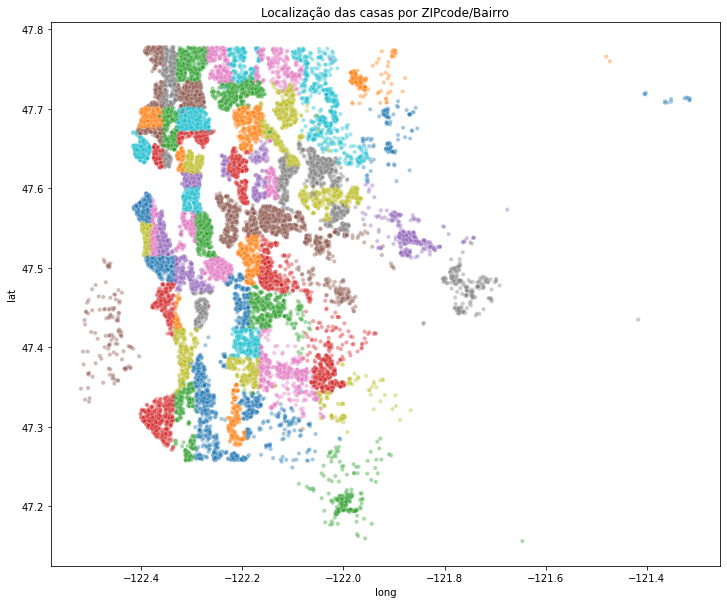

In [60]:
plt.figure(figsize=[12,10])
plt.title('Localização das casas por ZIPcode/Bairro')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, alpha=0.4, legend=False, 
hue = roof_c['zipcode'], palette='tab10')

plt.show()

## Insights
- Calcule o lucro/ perda de investimento caso o imóvel seja vendido mais de uma vez naquele período.


## Definição de Preço por pé<sup>2</sup>

In [5]:
roof_c['price_sqft'] = roof_c['price']/roof_c['sqft_living']
print(roof_c['price_sqft'])

0        188.050847
1        209.338521
2        233.766234
3        308.163265
4        303.571429
            ...    
21608    235.294118
21609    173.160173
21610    394.216667
21611    250.000000
21612    318.627451
Name: price_sqft, Length: 21613, dtype: float64


## Cálculo do Z score do \$/pé<sup>2</sup>
z-score = (valor - média)/desvpad

Neste caso o ideal era calcular o z-score baseade na média do valor do imóvel dentro de um raio de procura, tipo 5 km.
Ou a média por "bairro", ou seja 'zipcode'.


Primeiramente, o z-score foi calculado considerando a média e desviopadrão para tds os imóveis, consequentemente, os imóveis das áreas mais ricas ficaram supervalorizados, mas quando faz-se o z-score comparando o valor com os imóveis de mesmo ZIPcode, a realidade muda bastante, oportunidades de investimentos em áreas nobres passam a surgir, pois em comparação as redondezas, esses imóveis estão com um preço atrativo.

### z-score antigo

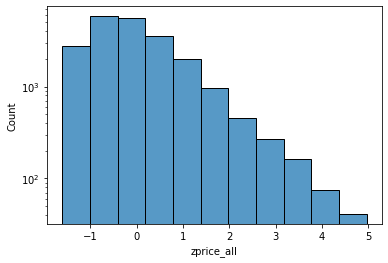

In [6]:
roof_c['zprice_all'] = pd.Series( (roof_c['price_sqft'] - (np.mean(roof_c['price_sqft']))) / np.std(roof_c['price_sqft']))

plt.figure()
sns.histplot(roof_c['zprice_all'], bins=11)
plt.yscale('log')
plt.show()




### z-score novo

In [106]:
for i,n in enumerate(roof_c['zipcode']):
    roof_c.loc[i, 'zprice'] = (roof_c.loc[i, 'price_sqft'] - np.mean(roof_c['price_sqft'][roof_c['zipcode'] == n])) / np.std(roof_c['price_sqft'][roof_c['zipcode'] == n])

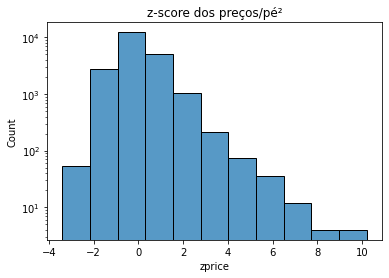

In [62]:
plt.figure()
plt.title('z-score dos preços/pé\u00b2')
sns.histplot(roof_c['zprice'], bins=11)
plt.yscale('log')
plt.show()

## Cálculo da diferença do tamanho do imóvel em relação a vizinhança
Quão discrepante for o imóvel, para mais ou para menos em relação a vizinhança, menor vai ser o score final, assumindo que nenhum comprador queira adquirir um imóvel fora dos padrões da vizinhança.

O Valor foi elevado ao quadrado para o efeito da discrepância não ser linear.

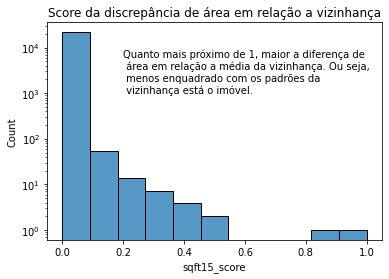

In [9]:
roof_c['sqft15_score'] = np.abs(roof_c['sqft_living'] - roof_c['sqft_living15'])**2
roof_c['sqft15_score'] /= max(roof_c['sqft15_score'])

plt.figure()
plt.title('Score da discrepância de área em relação a vizinhança')
sns.histplot(roof_c['sqft15_score'], bins=11)
plt.yscale('log')
anotacao = 'Quanto mais próximo de 1, maior a diferença de \n área em relação a média da vizinhança. Ou seja, \n menos enquadrado com os padrões da \n vizinhança está o imóvel.'
plt.annotate(anotacao, (0.2, 1000), )
plt.show()

## Contrução do Score do imóvel

Dividindo as variáves pelos seus ranges, trazendo todas para a mesma escala entre 0-1:

$Score = ( ('waterfront') + ('view'/4) + ('condition'/5) + ('grade'/13) + (('yr\_built' - 1900)/115) + ('yr\_renovated'/2015) - ('sqft15_score') ) / ('zprice' + abs(min('zprice')) + 1 )$

As variáveis do numerador ***aumentam o grau de atratividade*** de investimento em um imóvel, exceto ***'sqft15_score'*** o ***z-score*** representa quão distante da média o \$/m<sup>2</sup> está em relação ao King County em geral. ***Dividindo o score pelo z-score***, os imóveis com maiores valores de z-score, ou seja, com ***\$/m<sup>2</sup> muito acima da média, estão superprecificadas e tem seu score reduzido proporcionalmente***, reduzindo a tratividade de investimento.

In [119]:
pesos = dict({
    'waterfront':1.5,'view':1.2,
    'condition':1.2, 'grade':1,
    'yr_built':1, 'yr_renovated':0.5,
    'sqft15_score':1
})

roof_c['SCORE'] = (( (roof_c['waterfront'])*pesos['waterfront'] + (roof_c['view']/4)*pesos['view'] + ((roof_c['condition']-1)/4)*pesos['condition'] + ((roof_c['grade']-1)/12)*pesos['grade'] + ((roof_c['yr_built'] - 1900)/115)*pesos['yr_built'] - (roof_c['sqft15_score'])*pesos['sqft15_score']) / (roof_c['zprice'] + abs(min(roof_c['zprice'])) + 1))

# nao ta funcinando direto por causa dos zeros
' + (((roof_c['yr_renovated']/2015) - (1900/2015))*17.5217391297)*pesos['yr_renovated']

$roof_c['SCORE'] =$ 

$(( (roof_c['waterfront'])*pesos['waterfront'] + (roof_c['view']/4)*pesos['view'] + ((roof_c['condition']-1)/4)*pesos['condition'] + ((roof_c['grade']-1)/12)*pesos['grade'] + ((roof_c['yr_built'] - 1900)/115)*pesos['yr_built'] + (((roof_c['yr_renovated']/2015) - (1900/2015))*17.5217391297)*pesos['yr_renovated'] - (roof_c['sqft15_score'])*pesos['sqft15_score'])$

---

$(roof_c['zprice'] + abs(min(roof_c['zprice'])) + 1))$


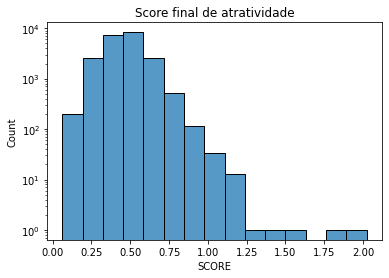

In [120]:
plt.figure()
plt.title('Score final de atratividade')
sns.histplot(roof_c['SCORE'], bins=15)
plt.yscale('log')
plt.show()

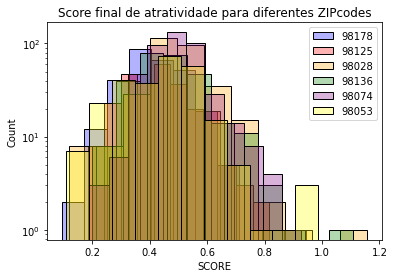

In [121]:
colors = ['blue', 'red', 'orange', 'green', 'purple', 'yellow']

plt.figure()
plt.title('Score final de atratividade para diferentes ZIPcodes')

for i, x in enumerate(set(roof_c.loc[range(0,len(roof_c['zipcode']), 4000),'zipcode'])):
    sns.histplot(roof_c['SCORE'][roof_c['zipcode'] == x], bins=11, color=colors[i], alpha = 0.3)
plt.yscale('log')
plt.legend(roof_c['zipcode'])
msg = 'Independente da classe \neconômica do bairro, a \ndistribuição do score \nestá dentro do mesmo range.'
plt.annotate(msg, (2,70))
plt.show()

## SCORE método antigo

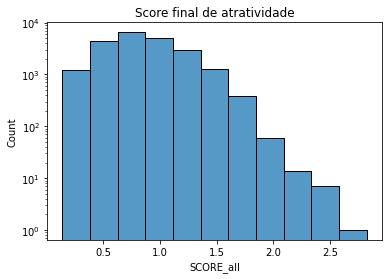

In [122]:
roof_c['SCORE_all'] = (( (roof_c['waterfront']) + (roof_c['view']/4) + (roof_c['condition']/5) + (roof_c['grade']/13) + ((roof_c['yr_built'] - 1900)/115) + ((roof_c['yr_renovated'])/2015)*0.5 - (roof_c['sqft15_score'])) / (roof_c['zprice_all'] + abs(min(roof_c['zprice_all'])) + 1))

plt.figure()
plt.title('Score final de atratividade')
sns.histplot(roof_c['SCORE_all'], bins=11)
plt.yscale('log')
plt.show()

## 5 imóveis mais atrativos para investimento

In [123]:
display(roof_c.loc[:,columns].sort_values('SCORE', axis=0, ascending=False, inplace=False).head())

,waterfront,view,condition,grade,yr_built,yr_renovated,sqft15_score,zprice,SCORE
326,0,0,3,9,1987,0,0.000033,-3.406637,2.023155
21372,0,2,3,10,2015,0,0.051392,-2.798331,1.802275
21050,0,4,3,12,2007,0,0.179331,-2.196254,1.568855
3844,0,0,3,7,2007,0,0.001356,-2.968844,1.411245
11436,0,0,3,7,2007,0,0.001531,-2.910999,1.356548


## 5 imóveis menos atrativos para investimento

In [124]:
display(roof_c.loc[:,columns].sort_values('SCORE', axis=0, ascending=True, inplace=False).head())

,waterfront,view,condition,grade,yr_built,yr_renovated,sqft15_score,zprice,SCORE
13629,0,0,1,5,1932,0,0.006305,5.423579,0.061574
19452,0,0,1,1,1963,0,0.023424,3.231770,0.068653
8606,0,0,3,5,1953,0,0.017210,10.080076,0.095052
8623,0,0,2,4,1953,0,0.008057,6.132391,0.095152
5832,0,0,2,3,1950,0,0.002014,4.770025,0.098013


## Localização dos 10 imóveis baseado na média de \$/pé<sup>2</sup> de todo o King County

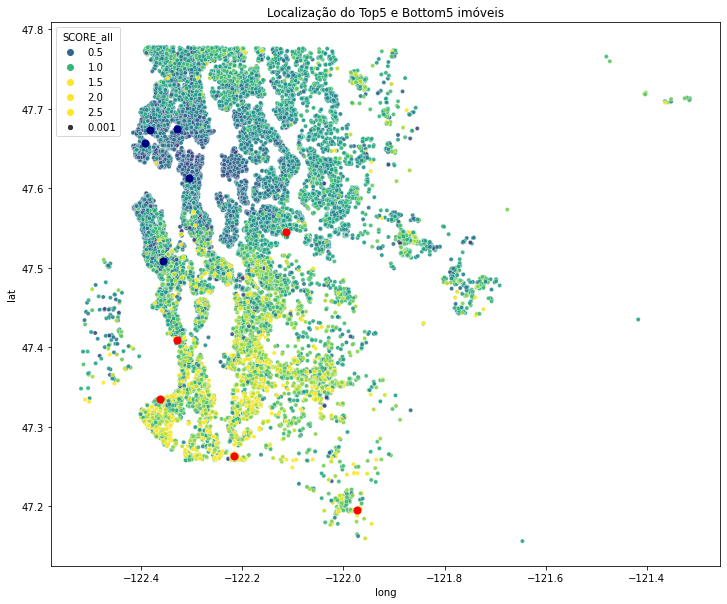

In [125]:
top5_all = roof_c.sort_values('SCORE_all', axis=0, ascending=False, inplace=False).head()
bottom5_all = roof_c.sort_values('SCORE_all', axis=0, ascending=True, inplace=False).head()

plt.figure(figsize=[12,10])
plt.title('Localização do Top5 e Bottom5 imóveis')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, 
alpha=0.9, legend=True, hue=roof_c['SCORE_all'], palette='viridis', hue_norm=(0,1.5))

top5 = plt.scatter(top5_all['long'], top5_all['lat'], c = 'red', s = 50)
bottom5 = plt.scatter(bottom5_all['long'], bottom5_all['lat'], c = 'navy', s = 50)
# plt.legend([top5, bottom5], roof_c['SCORE'])

plt.show()

## Localização dos 10 imóveis baseado na média de \$/pé<sup>2</sup> por cada ZIPcode de King County

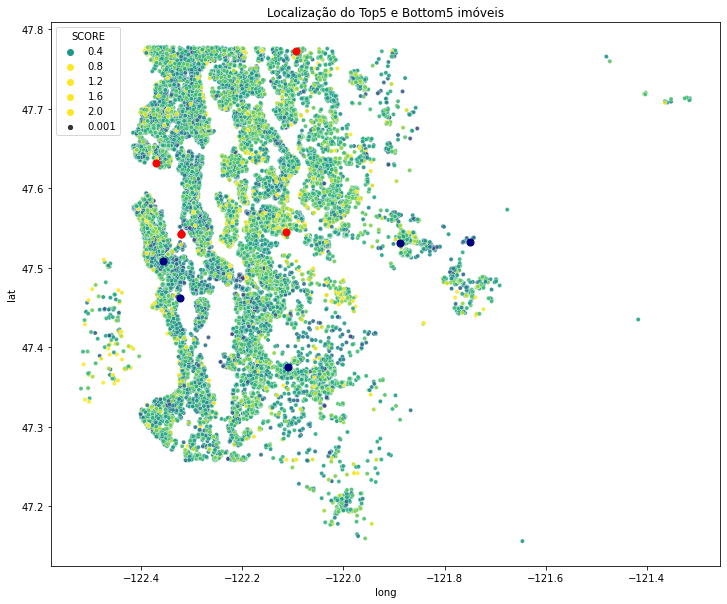

In [126]:
top5 = roof_c.sort_values('SCORE', axis=0, ascending=False, inplace=False).head()
bottom5 = roof_c.sort_values('SCORE', axis=0, ascending=True, inplace=False).head()

plt.figure(figsize=[12,10])
plt.title('Localização do Top5 e Bottom5 imóveis')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, 
alpha=0.9, legend=True, hue=roof_c['SCORE'], palette='viridis', hue_norm=(0,0.75))

plt.scatter(top5['long'], top5['lat'], c = 'red', s = 50)
plt.scatter(bottom5['long'], bottom5['lat'], c = 'navy', s = 50)
# plt.legend(roof_c['SCORE'])


plt.show()